#### Summary 

In this notebook im going to comprae two architectures for speaker identification on two datasets.

the architectures:
- LSTM model
- CNN model

the datasets:
- Digit spoken dataset (https://www.kaggle.com/divyanshu99/spoken-digit-dataset)
- Voxceleb dataset (http://www.robots.ox.ac.uk/~vgg/data/voxceleb/)

The main pupose of the research is to see the difference between "easy" data to a "messy" one. 
The spoken numbers dataset has 15 speakers while all the content is numbers that peaple say (classical for voice recognition and STT).
The Voxceleb dataset has ~250 speakers while all the content is free speech of celebs from youtube videos. 

To test this complexity question, i thought that the best approach is to take the basic features. I calculated the 20 mfcc features for every sample and feed it to a NN.

#### Imports 

In [1]:
import os
import re
import sys
import glob 
import keras
import random
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa.display
import scipy.io.wavfile
import tensorflow as tf
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import keras
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils, to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, History, ReduceLROnPlateau, CSVLogger
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Input, Flatten, Dropout, Activation, BatchNormalization

from utils import batch_generator, split_wav_files, one_hot_encode

# SEED = 42
# np.random.seed(SEED)

Using TensorFlow backend.


#### Speaker classification on Digit Audio 

##### Orgenize the dataset  

###### Choose dataset 

In [24]:
DATA_DIR = r'/mnt/tera/Audio/spoken_numbers_pcm' 
spoken_numbers_pcm = True

###### Order in folders 

In [25]:
preprocess_voxceleb = True
if not preprocess_voxceleb:
    print("Starting preprocess: moving and renaming files.")
    txt = input("[INFO] To Continue:")
    if txt == 'y':
        path = r'C:\Users\dbernsohn\Desktop\Folders\Speech\voxceleb\vox1_dev_wav_partaa\wav'
        for file in os.listdir(path):
            for afile in os.listdir(path + os.sep + file):
                wav_files = [f for f in glob.glob(path + os.sep + file + os.sep + afile + os.sep + "*.wav")]
                for wav in wav_files:
                    shutil.move(wav, wav[:-33] + os.sep + 'all' + os.sep + file + '_' + afile + '_' + wav[-9:])
        directoryname = r'C:\Users\dbernsohn\Desktop\Folders\Speech\voxceleb\vox1_dev_wav_partaa\all'
        lijstmetfiles = os.listdir(directoryname)
        for i in lijstmetfiles:
                os.rename(os.path.join(directoryname, i), os.path.join(directoryname, i.replace('-','')))

###### Create dataframe for the files 

In [26]:
if spoken_numbers_pcm:
    items = os.listdir(DATA_DIR)

    newlist = []
    for names in items:
        if names.endswith(".wav"):
            newlist.append(names)
    df = pd.DataFrame(newlist, columns = ['Path'])
    df['Name'] = df.Path.apply(lambda s: s.split('_')[1])
    df['Lable'] = df.Path.str[:1]
    df['Sample'] = df.Path.apply(lambda st: st[st.find("_")+1:st.find(".")])
    print(df.head())
else:
    df = pd.DataFrame(os.listdir(DATA_DIR), columns = ['Path'])
    df['Id'] = df.Path.str[:7]
    df['Sample'] = df.Path.apply(lambda st: st[st.find("_")+1:st.find(".")])
    df['Number'] = df.Path.str[-9:-4]
    print(df.head())

              Path   Name Lable     Sample
0  0_Agnes_100.wav  Agnes     0  Agnes_100
1  0_Agnes_120.wav  Agnes     0  Agnes_120
2  0_Agnes_140.wav  Agnes     0  Agnes_140
3  0_Agnes_160.wav  Agnes     0  Agnes_160
4  0_Agnes_180.wav  Agnes     0  Agnes_180


###### Spectrogram - example 

/mnt/tera/Audio/spoken_numbers_pcm/0_Agnes_100.wav


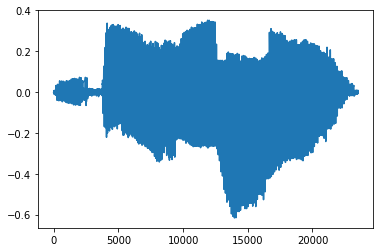

In [27]:
filename = df.Path[0]
print (DATA_DIR + os.sep + filename)

samples, sample_rate = librosa.load(DATA_DIR + os.sep + filename)
sample_rate, samples
plt.plot(samples)

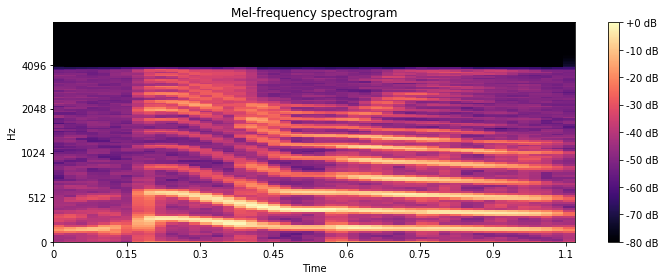

In [28]:
D = np.abs(librosa.stft(samples))**2
S = librosa.feature.melspectrogram(S=D, sr=sample_rate)
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128,
                                     fmax=8000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sample_rate,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

###### Build train and test sets  

In [29]:
files = glob.glob(DATA_DIR + "/*.wav")

if spoken_numbers_pcm:
    
    X_train, X_val = split_wav_files(files)
    
    x_train_labels = []
    for i in range(len(X_train)):
        label = X_train[i].split('/')[-1].split('_')[-2]
        if label not in x_train_labels:
            x_train_labels.append(label)

    x_test_labels = []
    for i in range(len(X_val)):
        label = X_val[i].split('/')[-1].split('_')[-2]
        if label not in x_test_labels:
            x_test_labels.append(label)
    
else:

    df_vc = df.Id.value_counts().rename_axis('unique_values').to_frame('counts')
    id_to_train_on = [x for x in df[df.Id.isin(df_vc[df_vc.counts >= 100].index.values)].Path]
    path_to_train_on = ["/mnt/tera/Audio/all/" + str(x) for x in df[df.Path.isin(id_to_train_on)].Path]
    X_train, X_val = split_wav_files(path_to_train_on)
    
    x_train_labels = []
    for i in range(len(X_train)):
        label = X_train[i].split('/')[-1].split('_')[0]
        x_train_labels.append(label)

    x_test_labels = []
    for i in range(len(X_val)):
        label = X_val[i].split('/')[-1].split('_')[0]
        x_test_labels.append(label)
        
label_binarizer = LabelBinarizer()
label_binarizer.fit(list(set(x_train_labels)))

x_train_labels_vector = one_hot_encode(x_train_labels, label_binarizer)
x_test_labels_vector = one_hot_encode(x_test_labels, label_binarizer)
print("The num of labels in train is: ", len(set(x_train_labels)))
print("The num of labels in test is: ", len(set(x_test_labels)))

# Training examples: 1920
# Validation examples: 480
The num of labels in train is:  15
The num of labels in test is:  15


##### Hyper parametrization 

In [30]:
n_features = 20
max_length = 8000
n_classes = len(set(x_train_labels))

In [31]:
learning_rate = 0.001
batch_size = 32
n_epochs = 50
dropout = 0.5

input_shape = (n_features, max_length)
steps_per_epoch = 50

##### LSTM model 

In [32]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=input_shape,
dropout=dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax'))

In [33]:
opt = Adam(lr=learning_rate) # decay=1e-2/n_epochs
model.compile(loss='categorical_crossentropy', optimizer=opt,
metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 256)           8455168   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               655488    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                1935      
Total params: 9,112,591
Trainable params: 9,112,591
Non-trainable params: 0
_________________________________________________________________


In [34]:
callbacks = [ModelCheckpoint('/mnt/tera/Audio/checkpoints/spoken_numbers_{epoch:02d}.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]

In [35]:
# 'spoken_numbers'
history = model.fit_generator(
    generator=batch_generator(X_train, batch_size, label_binarizer, max_length, task = 'spoken_numbers'),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    verbose=1,
    validation_data=batch_generator(X_val, batch_size, label_binarizer, max_length, task = 'spoken_numbers'),
    validation_steps=5,
    callbacks=callbacks
)

Epoch 1/50
50/50 [==============================] - 60s 1s/step - loss: 2.5491 - accuracy: 0.1600 - val_loss: 1.9623 - val_accuracy: 0.3500
Epoch 2/50
50/50 [==============================] - 37s 748ms/step - loss: 2.0777 - accuracy: 0.3081 - val_loss: 1.5715 - val_accuracy: 0.4313
Epoch 3/50
50/50 [==============================] - 33s 658ms/step - loss: 1.8263 - accuracy: 0.3787 - val_loss: 1.0079 - val_accuracy: 0.5813
Epoch 4/50
50/50 [==============================] - 32s 642ms/step - loss: 1.5722 - accuracy: 0.4819 - val_loss: 0.9394 - val_accuracy: 0.7312
Epoch 5/50
50/50 [==============================] - 30s 603ms/step - loss: 1.3330 - accuracy: 0.5362 - val_loss: 0.9551 - val_accuracy: 0.7437
Epoch 6/50
50/50 [==============================] - 29s 589ms/step - loss: 1.1986 - accuracy: 0.5888 - val_loss: 0.6090 - val_accuracy: 0.7688
Epoch 7/50
50/50 [==============================] - 30s 609ms/step - loss: 1.0522 - accuracy: 0.6413 - val_loss: 0.4216 - val_accuracy: 0.9125
Ep

In [36]:
df = pd.DataFrame(history.history)
df.head()

,val_loss,val_accuracy,loss,accuracy
0,1.962284,0.35000,2.549054,0.160000
1,1.571507,0.43125,2.077672,0.308125
2,1.007902,0.58125,1.826329,0.378750
3,0.939408,0.73125,1.572202,0.481875
4,0.955050,0.74375,1.332977,0.536250


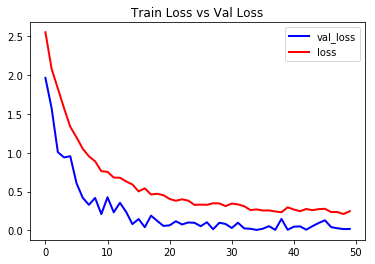

In [37]:
plt.plot('val_loss', data=df, marker='', color='blue', linewidth=2)
plt.plot('loss', data=df, marker='', color='red', linewidth=2)
plt.title('Train Loss vs Val Loss')
plt.legend()

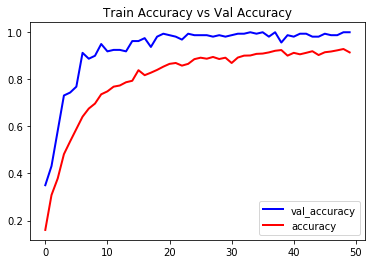

In [38]:
plt.plot('val_accuracy', data=df, marker='', color='blue', linewidth=2)
plt.plot('accuracy', data=df, marker='', color='red', linewidth=2)
plt.title('Train Accuracy vs Val Accuracy')
plt.legend()

##### CNN model 

In [39]:
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [40]:
opt = Adam(lr=learning_rate) # decay=1e-2/n_epochs
model.compile(loss='categorical_crossentropy', optimizer=opt,
metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 18, 32)            768032    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 32)            3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 32)             3104      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4, 32)             3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 32)            

In [41]:
callbacks = [ModelCheckpoint('/mnt/tera/Audio/checkpoints/spoken_numbers_cnn_{epoch:02d}.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]

In [42]:
# 'spoken_numbers'
history = model.fit_generator(
    generator=batch_generator(X_train, batch_size, label_binarizer, max_length, task = 'spoken_numbers'),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    verbose=1,
    validation_data=batch_generator(X_val, batch_size, label_binarizer, max_length, task = 'spoken_numbers'),
    validation_steps=5,
    callbacks=callbacks
)

Epoch 1/50
50/50 [==============================] - 23s 463ms/step - loss: 2.7621 - accuracy: 0.0787 - val_loss: 2.6753 - val_accuracy: 0.0750
Epoch 2/50
50/50 [==============================] - 22s 430ms/step - loss: 2.6367 - accuracy: 0.1181 - val_loss: 2.4965 - val_accuracy: 0.1500
Epoch 3/50
50/50 [==============================] - 22s 447ms/step - loss: 2.3992 - accuracy: 0.1931 - val_loss: 2.2357 - val_accuracy: 0.2375
Epoch 4/50
50/50 [==============================] - 22s 440ms/step - loss: 2.0548 - accuracy: 0.2869 - val_loss: 1.7486 - val_accuracy: 0.3688
Epoch 5/50
50/50 [==============================] - 22s 441ms/step - loss: 1.8963 - accuracy: 0.3306 - val_loss: 1.2049 - val_accuracy: 0.5750
Epoch 6/50
50/50 [==============================] - 22s 440ms/step - loss: 1.6995 - accuracy: 0.3931 - val_loss: 0.9867 - val_accuracy: 0.6250
Epoch 7/50
50/50 [==============================] - 22s 446ms/step - loss: 1.5247 - accuracy: 0.4606 - val_loss: 1.2018 - val_accuracy: 0.6625

In [43]:
df = pd.DataFrame(history.history)
df.head()

,val_loss,val_accuracy,loss,accuracy
0,2.675273,0.07500,2.762143,0.078750
1,2.496541,0.15000,2.636724,0.118125
2,2.235703,0.23750,2.399224,0.193125
3,1.748564,0.36875,2.054757,0.286875
4,1.204897,0.57500,1.896349,0.330625


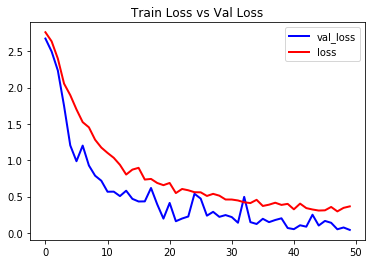

In [44]:
plt.plot('val_loss', data=df, marker='', color='blue', linewidth=2)
plt.plot('loss', data=df, marker='', color='red', linewidth=2)
plt.title('Train Loss vs Val Loss')
plt.legend()

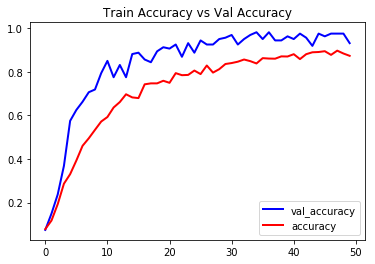

In [45]:
plt.plot('val_accuracy', data=df, marker='', color='blue', linewidth=2)
plt.plot('accuracy', data=df, marker='', color='red', linewidth=2)
plt.title('Train Accuracy vs Val Accuracy')
plt.legend()

#### Speaker classification on Voxceleb 

##### Orgenize the dataset  

###### Choose dataset 

In [2]:
DATA_DIR = r'/mnt/tera/Audio/all'
spoken_numbers_pcm = False

###### Order in folders 

In [3]:
preprocess_voxceleb = True
if not preprocess_voxceleb:
    print("Starting preprocess: moving and renaming files.")
    txt = input("[INFO] To Continue:")
    if txt == 'y':
        path = r'C:\Users\dbernsohn\Desktop\Folders\Speech\voxceleb\vox1_dev_wav_partaa\wav'
        for file in os.listdir(path):
            for afile in os.listdir(path + os.sep + file):
                wav_files = [f for f in glob.glob(path + os.sep + file + os.sep + afile + os.sep + "*.wav")]
                for wav in wav_files:
                    shutil.move(wav, wav[:-33] + os.sep + 'all' + os.sep + file + '_' + afile + '_' + wav[-9:])
        directoryname = r'C:\Users\dbernsohn\Desktop\Folders\Speech\voxceleb\vox1_dev_wav_partaa\all'
        lijstmetfiles = os.listdir(directoryname)
        for i in lijstmetfiles:
                os.rename(os.path.join(directoryname, i), os.path.join(directoryname, i.replace('-','')))

###### Create dataframe for the files 

In [4]:
if spoken_numbers_pcm:
    items = os.listdir(DATA_DIR)

    newlist = []
    for names in items:
        if names.endswith(".wav"):
            newlist.append(names)
    df = pd.DataFrame(newlist, columns = ['Path'])
    df['Name'] = df.Path.apply(lambda s: s.split('_')[1])
    df['Lable'] = df.Path.str[:1]
    df['Sample'] = df.Path.apply(lambda st: st[st.find("_")+1:st.find(".")])
    print(df.head())
else:
    df = pd.DataFrame(os.listdir(DATA_DIR), columns = ['Path'])
    df['Id'] = df.Path.str[:7]
    df['Sample'] = df.Path.apply(lambda st: st[st.find("_")+1:st.find(".")])
    df['Number'] = df.Path.str[-9:-4]
    print(df.head())

                           Path       Id            Sample Number
0  id10011_R8SJgrcjKI_00001.wav  id10011  R8SJgrcjKI_00001  00001
1  id10011_R8SJgrcjKI_00002.wav  id10011  R8SJgrcjKI_00002  00002
2  id10011_R8SJgrcjKI_00003.wav  id10011  R8SJgrcjKI_00003  00003
3  id10011_R8SJgrcjKI_00004.wav  id10011  R8SJgrcjKI_00004  00004
4  id10011_R8SJgrcjKI_00005.wav  id10011  R8SJgrcjKI_00005  00005


###### Spectrogram - example 

/mnt/tera/Audio/all/id10011_R8SJgrcjKI_00001.wav


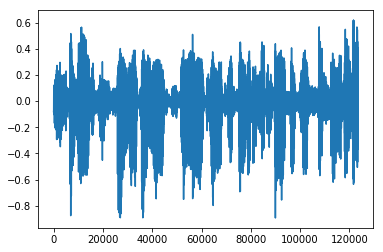

In [5]:
filename = df.Path[0]
print (DATA_DIR + os.sep + filename)

samples, sample_rate = librosa.load(DATA_DIR + os.sep + filename)
sample_rate, samples
plt.plot(samples)

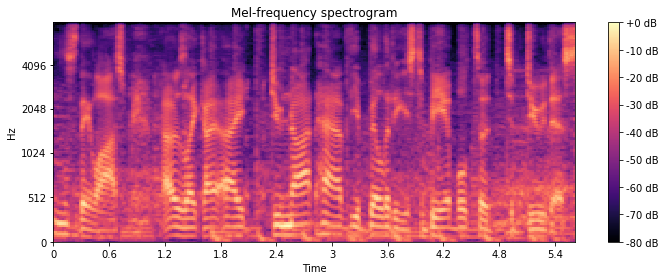

In [6]:
D = np.abs(librosa.stft(samples))**2
S = librosa.feature.melspectrogram(S=D, sr=sample_rate)
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128,
                                     fmax=8000)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sample_rate,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

###### Build train and test sets  

In [7]:
files = glob.glob(DATA_DIR + "/*.wav")

if spoken_numbers_pcm:
    
    X_train, X_val = split_wav_files(files)
    
    x_train_labels = []
    for i in range(len(X_train)):
        label = X_train[i].split('/')[-1].split('_')[-2]
        if label not in x_train_labels:
            x_train_labels.append(label)

    x_test_labels = []
    for i in range(len(X_val)):
        label = X_val[i].split('/')[-1].split('_')[-2]
        if label not in x_test_labels:
            x_test_labels.append(label)
    
else:

    df_vc = df.Id.value_counts().rename_axis('unique_values').to_frame('counts')
    id_to_train_on = [x for x in df[df.Id.isin(df_vc[df_vc.counts >= 200].index.values)].Path]
    path_to_train_on = ["/mnt/tera/Audio/all/" + str(x) for x in df[df.Path.isin(id_to_train_on)].Path]
    X_train, X_val = split_wav_files(path_to_train_on)
    
    x_train_labels = []
    for i in range(len(X_train)):
        label = X_train[i].split('/')[-1].split('_')[0]
        x_train_labels.append(label)

    x_test_labels = []
    for i in range(len(X_val)):
        label = X_val[i].split('/')[-1].split('_')[0]
        x_test_labels.append(label)
        
label_binarizer = LabelBinarizer()
label_binarizer.fit(list(set(x_train_labels)))

x_train_labels_vector = one_hot_encode(x_train_labels, label_binarizer)
x_test_labels_vector = one_hot_encode(x_test_labels, label_binarizer)
print("The num of labels in train is: ", len(set(x_train_labels)))
print("The num of labels in test is: ", len(set(x_test_labels)))

# Training examples: 11085
# Validation examples: 2772
The num of labels in train is:  51
The num of labels in test is:  51


##### Hyper parametrization 

In [8]:
n_features = 20
max_length = 8000
n_classes = len(set(x_train_labels))

In [9]:
learning_rate = 0.001
batch_size = 32
n_epochs = 50
dropout = 0.5

input_shape = (n_features, max_length)
steps_per_epoch = 50

##### LSTM model 

In [17]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=input_shape, dropout=dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax'))

In [18]:
opt = Adam(lr=learning_rate) # decay=1e-2/n_epochs
model.compile(loss='categorical_crossentropy', optimizer=opt,
metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 256)           8455168   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               655488    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 51)                6579      
Total params: 9,117,235
Trainable params: 9,117,235
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [ModelCheckpoint('/mnt/tera/Audio/checkpoints/Voxceleb_lstm_{epoch:02d}.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]

In [20]:
history = model.fit_generator(
    generator=batch_generator(X_train, batch_size, label_binarizer, max_length, task = 'Voxceleb'),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    verbose=1,
    validation_data=batch_generator(X_val, batch_size, label_binarizer, max_length, task = 'Voxceleb'),
    validation_steps=5,
    callbacks=callbacks
)

Epoch 1/50
50/50 [==============================] - 344s 7s/step - loss: 3.9467 - accuracy: 0.0456 - val_loss: 3.8995 - val_accuracy: 0.0875
Epoch 2/50
50/50 [==============================] - 315s 6s/step - loss: 3.7468 - accuracy: 0.0881 - val_loss: 3.2842 - val_accuracy: 0.1375
Epoch 3/50
50/50 [==============================] - 316s 6s/step - loss: 3.5419 - accuracy: 0.1262 - val_loss: 3.1950 - val_accuracy: 0.1750
Epoch 4/50
50/50 [==============================] - 300s 6s/step - loss: 3.3565 - accuracy: 0.1731 - val_loss: 3.1687 - val_accuracy: 0.2313
Epoch 5/50
50/50 [==============================] - 310s 6s/step - loss: 3.2066 - accuracy: 0.1956 - val_loss: 2.9277 - val_accuracy: 0.3750
Epoch 6/50
50/50 [==============================] - 301s 6s/step - loss: 3.0124 - accuracy: 0.2400 - val_loss: 2.3839 - val_accuracy: 0.3688
Epoch 7/50
50/50 [==============================] - 303s 6s/step - loss: 2.8921 - accuracy: 0.2619 - val_loss: 2.1468 - val_accuracy: 0.3750
Epoch 8/50
50

In [21]:
df = pd.DataFrame(history.history)
df.head()

,val_loss,val_accuracy,loss,accuracy
0,3.899451,0.08750,3.946669,0.045625
1,3.284231,0.13750,3.746777,0.088125
2,3.195043,0.17500,3.541879,0.126250
3,3.168732,0.23125,3.356480,0.173125
4,2.927704,0.37500,3.206591,0.195625


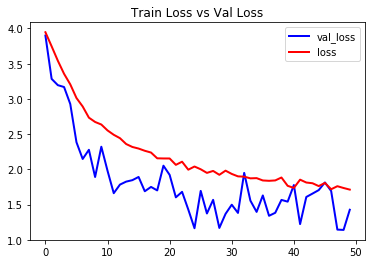

In [22]:
plt.plot('val_loss', data=df, marker='', color='blue', linewidth=2)
plt.plot('loss', data=df, marker='', color='red', linewidth=2)
plt.title('Train Loss vs Val Loss')
plt.legend()

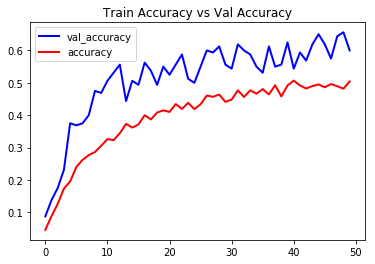

In [23]:
plt.plot('val_accuracy', data=df, marker='', color='blue', linewidth=2)
plt.plot('accuracy', data=df, marker='', color='red', linewidth=2)
plt.title('Train Accuracy vs Val Accuracy')
plt.legend()

##### CNN model 

In [10]:
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
opt = Adam(lr=learning_rate) # decay=1e-2/n_epochs
model.compile(loss='categorical_crossentropy', optimizer=opt,
metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 18, 32)            768032    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 32)             3104      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 32)             3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 32)            

In [12]:
callbacks = [ModelCheckpoint('/mnt/tera/Audio/checkpoints/Voxceleb_cnn_{epoch:02d}.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_acc', patience=2)]

In [13]:
# 'spoken_numbers'
history = model.fit_generator(
    generator=batch_generator(X_train, batch_size, label_binarizer, max_length, task = 'Voxceleb'),
    steps_per_epoch=steps_per_epoch,
    epochs=n_epochs,
    verbose=1,
    validation_data=batch_generator(X_val, batch_size, label_binarizer, max_length, task = 'Voxceleb'),
    validation_steps=5,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50/50 [==============================] - 298s 6s/step - loss: 5.2723 - accuracy: 0.0231 - val_loss: 3.8422 - val_accuracy: 0.0250


/home/rs/miniconda3/envs/nlp/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/50
50/50 [==============================] - 284s 6s/step - loss: 4.1969 - accuracy: 0.0225 - val_loss: 3.9625 - val_accuracy: 0.0562
Epoch 3/50
50/50 [==============================] - 284s 6s/step - loss: 4.1137 - accuracy: 0.0206 - val_loss: 3.8988 - val_accuracy: 0.0437
Epoch 4/50
50/50 [==============================] - 288s 6s/step - loss: 4.0335 - accuracy: 0.0356 - val_loss: 3.8410 - val_accuracy: 0.0625
Epoch 5/50
50/50 [==============================] - 281s 6s/step - loss: 3.9689 - accuracy: 0.0331 - val_loss: 3.8737 - val_accuracy: 0.0375
Epoch 6/50
50/50 [==============================] - 283s 6s/step - loss: 3.9814 - accuracy: 0.0394 - val_loss: 3.8711 - val_accuracy: 0.1000
Epoch 7/50
50/50 [==============================] - 283s 6s/step - loss: 3.9503 - accuracy: 0.0487 - val_loss: 3.9382 - val_accuracy: 0.0750
Epoch 8/50
50/50 [==============================] - 279s 6s/step - loss: 3.8953 - accuracy: 0.0494 - val_loss: 3.7835 - val_accuracy: 0.0625
Epoch 9/50
50

In [14]:
df = pd.DataFrame(history.history)
df.head()

,val_loss,val_accuracy,loss,accuracy
0,3.842235,0.02500,5.272256,0.023125
1,3.962482,0.05625,4.196873,0.022500
2,3.898781,0.04375,4.113665,0.020625
3,3.841018,0.06250,4.033471,0.035625
4,3.873723,0.03750,3.968914,0.033125


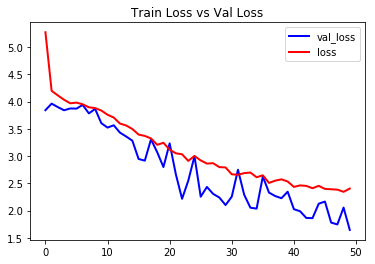

In [15]:
plt.plot('val_loss', data=df, marker='', color='blue', linewidth=2)
plt.plot('loss', data=df, marker='', color='red', linewidth=2)
plt.title('Train Loss vs Val Loss')
plt.legend()

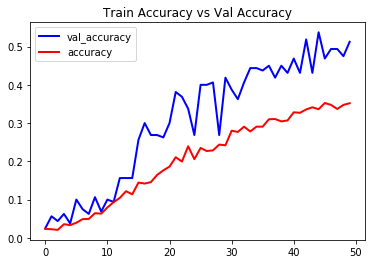

In [16]:
plt.plot('val_accuracy', data=df, marker='', color='blue', linewidth=2)
plt.plot('accuracy', data=df, marker='', color='red', linewidth=2)
plt.title('Train Accuracy vs Val Accuracy')
plt.legend()